# Expectation Maximisation

$
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\z}{\mathbf{z}}
\newcommand{\class}{\mathcal{C}}
\newcommand{\mean}{\boldsymbol{\mu}}
\newcommand{\cov}{\boldsymbol{\Sigma}}
\newcommand{\icov}{\boldsymbol{\Sigma}^{-1}}
\newcommand{\normdist}{\mathcal{N}}
\newcommand{\tp}{\top}
\newcommand{\params}{\mathbf{\theta}}
$

| Elt. | Val. |
|--|--|
| **Names** | *Thibault Douzon & Georgios Lioutas* |
| **Group** | *AML3* |

In this lab we will build a probabilistic classifier and estimate its parameters. In order to illustrate how the complexity of learning changes when we do not observe all the variables, we will start with the model depicted in figure 1. We will then switch to the graphical model depicted in figure 2 and compare the two
models’ performance.

Read through the complete exercise handout before starting your implementation: the hints at the end, and the instructions for the subsequent exercises will help you for the current one

## Gaussian Distribution

 <img src="observed.png"> 
**Figure 1**: Bayesian classifier with Normally distributed observations. The class labels C are discrete variables in one-of-K format. The observations x are multivariate and continuous, and their distribution is described with a Gaussian probability density function. 


In this model, we want to find the posterior probability
$p(\class_k|\x_n)$ for all data points $\x_n$. We get this from Bayes' rule

$$
  p(\class_k|\x_n) = \frac{ p(\x_n|\class_k) p(\class_k) }{
    \sum_j p(\x_n|\class_j) p(\class_j) },
$$

where we can see from the graph that the data elements are
conditionally independent given the class and we model the
class-conditional probability with a normal distribution

$$
  p(\x_n|\class_k) = \normdist(\x_n;\mean_k,\cov_k)\\
  = \frac{1}{(2\pi)^{d/2}|\cov|^{1/2}} \exp -\frac{1}{2}
    (\x_n-\mean_k)^\tp \icov_k (\x_n-\mean_k)
$$


We load the data in `target.npz`, which consists
of two classes `A` and `B`. Split the data in train and test
sets and plot the training data, in order to get a feel for it. Just by looking at the data, do you think the model will perform well?


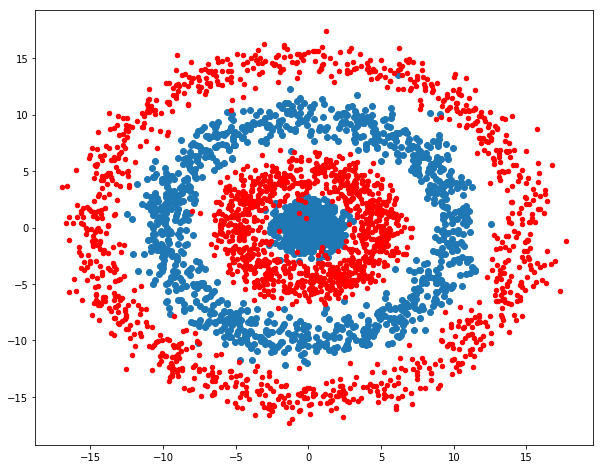

In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab
import time
from IPython import display


from matplotlib.patches import Ellipse

pylab.rcParams['figure.figsize'] = (10.0, 8.0)


# Our own implementation of the multivariate Gaussian Distribution
class Gauss:
    def __init__(self, mu, sigma):
        """Initialise a distribution with mean mu and covariance sigma
        
        Precompute and store everything that is not dependent
        on the datapont, so as to keep things efficient"""
        D = mu.size
        
        self.mu = mu
        self.sigma = sigma
        self.icov = np.linalg.inv(sigma)
        sign,ld = np.linalg.slogdet(sigma)
        if sign != 1:
            print("Sign=",sign)
        
        self.lognum = D*np.log(2*np.pi) + ld
                            
    def logprob(self,x):
        """return log(p(x))"""
        N = x.shape[0]
        res = np.zeros(N)
        for i in range(N):
            d = x[i,:]-self.mu
            res[i] = -.5 * (self.lognum + np.dot(np.dot(d,self.icov),d))
        return res
    
    def prob(self,x):
        """return p(x)"""
        return np.exp(self.logprob(x))

# Load in the data
D = np.load("target.npz")
data = D['data']
labels = D['labels']
A=data[labels==0,:]
B=data[labels==1,:]

nA = A.shape[0]
nB = B.shape[0]
N = nA + nB

data = np.vstack((A,B))
#print(A)
#print(B)
#print(data)
plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1],20,'red')

labels = np.concatenate((np.zeros(nA),np.ones(nB)))
#print(labels)

perm = np.random.permutation(N)
datap = data[perm,:]
labelp = labels[perm]

S = int(4*N/5)

trainData = datap[:S,:]
trainLab  = labelp[:S]
testData  = datap[S:,:]
testLab   = labelp[S:]


**Question 1 [5 marks]**: One Gaussian distribution per class.

Do the training by maximum likelihood, which consists of finding the prior probabilities for each class, $p(\class_k)$, and the parameters of the class-conditional distributions, the means $\mean_k$ and covariance matrices $\cov_k$. Now use Bayes' rule to compute the most likely class label for each data point in the test set.  Include the resulting confusion matrix and error rate you report.



In [2]:
#[ANSQ1]
def predict(x, gauss, prior):
    evidence = np.zeros(np.shape(gauss[0].prob(x)))
    for g,p in zip(gauss, prior):
        evidence += g.prob(x)*p
    return np.array([g.prob(x)*p/evidence for g,p in zip(gauss, prior)]).T

def predict_class(x, gauss, prior):
    res = predict(x, gauss, prior)
    return [list(r).index(max(r)) for r in res]

prior_l = [len(i)/len(data) for i in [A,B]]

gauss_l = [Gauss(np.mean(i, axis=0), np.cov(i.T)) for i in [A,B]]

x = A
print(gauss_l[0].prob(x))

conf_mat = np.zeros((2,2))

for real, x in enumerate([A,B]):
    conf_mat[real,real] = list(predict_class(x, gauss_l, prior_l)).count(real)
    conf_mat[1-real,real] = list(predict_class(x, gauss_l, prior_l)).count(1-real)

print(conf_mat)


print('Error rate: {}'.format((conf_mat[1,0]+conf_mat[0,1])/len(data)))
#[/ANSQ1]


[0.00031181 0.00114291 0.00076101 ... 0.00585513 0.00607777 0.00583538]
[[1125. 1000.]
 [ 875. 1000.]]
Error rate: 0.46875


## Mixture of Gaussians

<img src="latent.png"> 
**Figure 2**: Graphical model of a Bayesian classifier with observations described by a Mixture of Gaussians
(MOG). Each class has a number of mixture elements, which are each modelling part of the data. Which
datapoints belong to which mixture element is controlled by the latent variable $\z$.


In this model, the class-conditional distributions $p(\x|\class_k)$ are
modelled by a **mixture** of Gaussians rather than a single Gaussian, so that the total data-likelihood
\begin{align}
  p(\x_n,\class_k) &= p(\class_k) \sum_j p(\x_n|z_j,\class_k)p(z_j|\class_k),
\end{align}
where
\begin{align}
  p(\x_n|z_j,\class_k) = \normdist(\x_n;\mean_{jk},\cov_{jk}).
\end{align}

Since the latent variables controlling the mixture components are not observed, we need to optimise the log-likelihood with the EM
algorithm. You are provided with some code to help you pull this off:

In [53]:

def invalid(sigma):
    """Is this a valid covariance matrix?"""
    if np.isfinite(sigma).all():
        return np.linalg.cond(sigma)>1e3
    return True

colours = [
    [1,0,0],
    [0,1,0],
    [1,1,0],
    [1,0,1],
    [0,1,1],
    [1,1,1],
]

class MoG:
    def __init__(self,data,nMix=2):
        self.pi = np.ones(nMix) / nMix
        nPoints, nDim = data.shape
        self.nMix = nMix
        self.data = data
        mu = np.mean(data)
        self.lik = []
        for i in range(nMix):
            self.lik.append(Gauss(mu + 10*np.random.randn(nDim),10*np.eye(nDim)))
            
    def em(self,maxIter=100,minInc=1e-1):
        llhist = np.zeros(maxIter)
        for iteration in range(maxIter):
            resp, ll = self.expectation()
            llhist[iteration]=ll
            
            #print(iteration, llhist[:5])
            if iteration>0:
                delta = llhist[iteration] - llhist[iteration-1]
                print("Iteration",iteration,":",delta)
#                 print llhist[:iteration+1],llhist[iteration], llhist[iteration-1],delta
                if delta < minInc:
                    if delta < 0.:
                        print("WARNING: log-likelihood decreased in iteration",iteration)
                    else:
                        print("WARNING: log-likelihood staying the same")
                    llhist = llhist[:iteration]
                    break
            
            self.maximisation(resp)
            #if iteration%10==0:
            self.plot()
        return llhist
            
    def expectation(self):
        """Compute p(z|x,\theta)"""
        #[ANSQ2]
        
        evidence = np.zeros(self.data.shape[0])
        for g, p in zip(self.lik, self.pi):
            evidence += g.prob(self.data)*p
        
        resp = np.array([g.prob(self.data)*p/evidence for g,p in zip(self.lik, self.pi)]).T
        
        ll = 0
        prob_matrix = np.array([g.prob(self.data) for g in self.lik])
        for n in range(self.data.shape[0]):
            ll_i = 0
            for k in range(self.nMix):
                ll_i += self.pi[k] * prob_matrix[k,n]
                
            ll += np.log(ll_i)
            
        # ll = sum(np.max([g.logprob(self.data)+np.log(p) for g,p in zip(self.lik, self.pi)], axis=0))
        
        return np.array(resp), ll
        #[/ANSQ2]
    
    def maximisation(self,resp):
#[ANSQ3]
        tot_resp = np.sum(resp, axis=0)
        
        mu_new = []
        for i in range(self.nMix):
            m = np.sum(np.array([r[i]*x for r,x in zip(resp, self.data)]), axis=0)/tot_resp[i]
            mu_new.append(m)
            
        # mu_new = np.sum(np.array([[ri*x/tot_resp[i] for i, ri in enumerate(r)] for r, x in zip(resp, self.data)]), axis=0)
        # print(mu_new)
        
        # TODO: sigma
        sigma_new = []
        for i in range(self.nMix):
            s = np.sum(np.array([r[i] * np.outer(x-mu_new[i], x-mu_new[i]).T for r, x in zip(resp, self.data) ]), axis=0)/tot_resp[i]
            if invalid(s):
                s = 10*np.eye(nDim)
            sigma_new.append(s)
        # print(sigma_new)
        
        self.lik = []
        for i in range(self.nMix):
            self.lik.append(Gauss(mu_new[i], sigma_new[i]))
            
        
        
        
        return
#[/ANSQ3]
            
    def plot(self):
        #return
        fig = plt.gcf()
        display.display(fig)
        display.clear_output(wait=True)
        plt.clf()        
        ax = fig.add_subplot(111, aspect='equal')
        plt.scatter(self.data[:,0],self.data[:,1])
        for m in range(self.nMix):
            [val,vect] = np.linalg.eig(self.lik[m].sigma)
            e = Ellipse(xy=self.lik[m].mu, width=2*np.sqrt(val[0]), height=2*np.sqrt(val[1]), angle=180*np.arctan2(vect[0,0],vect[1,0])/np.pi)
                    
            e.set_facecolor(colours[m%len(colours)])
            ax.add_artist(e)
        plt.show()
        time.sleep(.1)
        
    def likelihood(self,data):
        """Compute the marginal likelihood of the data given the mixture model, p(x|\theta), for
        all elements in `data`"""
        #print(data)
        p = np.zeros(data.shape[0])
        for m in range(self.nMix):
            p += self.pi[m] * self.lik[m].prob(data)# normPDF(data,self.mu[m],self.sigma[m])
        return p
    

#mog = MoG(B,15)
#llhist = mog.em()

#plt.figure()
#plt.plot(llhist)


The code above requires a number of methods in order to work,
implementing the intialisation, E-step and M-step of the EM
algorithm. Those methods are:
 
* `(resp, ll) = expectation()` which implements the E-step
  of the algorithm. It uses the data, and the current parameter values. The function does not change
  the parameters but computes `resp`, a matrix that contains the
  probability of each mixture component given the data
  $p(\z|\x,\params)$, and `ll`, the log-likelihood of the data set
  under the mixture model. This is **Question 2 [10 marks]**
* `maximisation(resp)` wich uses the data and takes as inputs the corresponding responsibilities. The method updates the class by storing the updated parameter values. This is **Question 3 [10 marks]**

Include comments in your answer, explaining
how you compute the responsibilities $p(\z|\x,\params)$ and what the
updates are that maximise the complete expected log-likelihood.


**Question 4 [10 marks]**
Use the same data in `target.npz`, and optimise the model parameters for the classifier with
mixture-of-Gaussians distributions. Use the same train and test sets
as for exercise1 and compare the performance of both
classifiers. Discuss the differences you found.

*Optional Extra:* The contour plots of the distributions do not
reflect the priors ($p(\z|\class_l)$) and therefore do not give you an
exact idea of the probability density under the model. In order to
visualise that, you could plot the probability density under both
models in three dimensions.


### Hints
1. Include a check in your M-step to avoid singularities. You can
  check this by computing `c = np.linalg.cond(SIGMA)`: if c becomes larger
  than a given threshold (say, $10^{10}$), do not perform the
  parameter update and reset the mean and covariance. The provided function,
  `invalid(SIGMA)`, does that check for you.
1. The responsibilities $p(\z|\x,\params)$ are stored in the matrix
  `Q` in the E-step of the algorithm. You know the size of this
  matrix in advance: if you create a matrix of zeros of that size and
  fill in the values, your code will be much more efficient than if
  your grow the matrix as you compute the values.

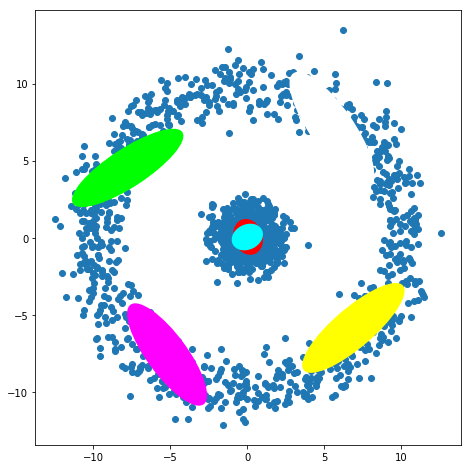

Iteration 25 : 0.09648090436712664


In [61]:
print('Computing A')
mog_A = MoG(A,6)
llhist_A = mog_A.em()



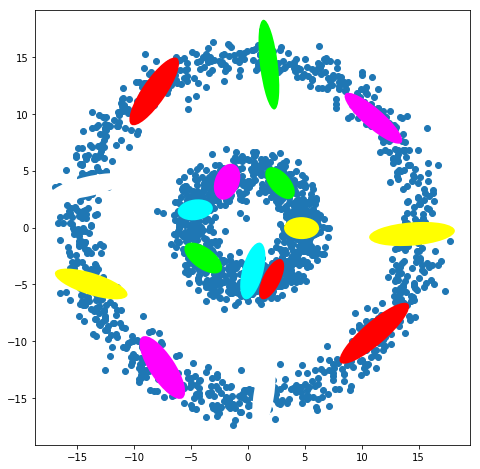

In [58]:
print('Computing B')
mog_B = MoG(B, 16)
llhist_B = mog_B.em()

In [62]:
# [ANSQ4] Do not modify this line
# Answer to Q4
def predict_mix(x, mix_l, prior_l):
    evidence = 0
    for mix,p in zip(mix_l, prior_l):
        evidence += mix.likelihood(x)*p
    return np.array([mix.likelihood(x)*p/evidence for mix,p in zip(mix_l, prior_l)]).T

def predict_mix_class(x, mix_l, prior_l):
    return np.array([np.argmax(i) for i in predict_mix(x, mix_l, prior_l) ])




prior_l = [len(i)/len(data) for i in [A,B]]
mix_l = [mog_A, mog_B]


conf_mat = np.zeros((2,2))

for real, x in enumerate([A,B]):
    conf_mat[real,real] = list(predict_mix_class(x, mix_l, prior_l)).count(real)
    conf_mat[1-real,real] = list(predict_mix_class(x, mix_l, prior_l)).count(1-real)

print(conf_mat)


print('Error rate: {}'.format((conf_mat[1,0]+conf_mat[0,1])/len(data)))
print('Done')

#[/ANSQ4]

[[1976.   52.]
 [  24. 1948.]]
Error rate: 0.019
Done


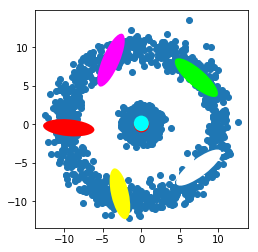

Iteration 58 : 0.0960801886558329
[0.40775, 0.161, 0.04225, 0.03875, 0.0205, 0.018]


In [7]:
errors= []
for n in range(2,8):
    temp_B = MoG(B , 2*n)
    temp_A = MoG(A, n)
    temp_list_B = temp_B.em()
    temp_list_A = temp_A.em()
    conf_mat = np.zeros((2,2))
    mix_temp  = [temp_A, temp_B]
    for real, x in enumerate([A,B]):
        conf_mat[real,real] = list(predict_mix_class(x, mix_temp, prior_l)).count(real)
        conf_mat[1-real,real] = list(predict_mix_class(x, mix_temp, prior_l)).count(1-real)
    temp_error =(conf_mat[1,0]+conf_mat[0,1])/len(data)
    errors.append(temp_error)
print(errors)

## Discussion of the Implementation 

**Question 5 [8 marks]**

Discuss the following with your teammate and include your thoughts in
your report:
1. What is a sensible way to initialise the parameters of your
  model?
1. How many components should you try? Having plotted the data, can
  you guess what number of components should be optimal? How does your
  classification accuracy evolve as the number of components change?
1. Do the results depend on the initialisation?
1. Why is hint 1 important?


[ANSQ5] Do not modify this line

Answer to Q5
1) Put high variance to avoid null probabilities due to numerical errors, and high noise in the mean to converge to different solutions. 

2) From excersice 4 we notices that B needs mpre components to work so we tried a range of n and 2n components for A and B respectively. The results were : [0.438, 0.1365, 0.04225, 0.02525, 0.0215, 0.02225]. As can see that error rate minimizes for n=6 and then starts to rise again.

3) Yes it does, but not much

4) Otherwise we could end up in a singularity which breaks convergency because it's a global optimum with infinity likelihood we don't want.


[/ANSQ5]


## Log-Probabilities

As we have seen in the class, one problem that occurs often when doing probabilistic modelling, is that since probabilities lay in the range $[0,\dots,1]$, the joint probability of multiple variables becomes very small very fast. This is a problem, because computers can only represent numbers with a finite precision and too small a probability will result in an
underflow, hence introducing numerical errors in an otherwise mathematically correct algorithm.

The solution that is typically used is then to use the logarithm of
probabilities, rather than the probabilities themselves. The products
of probabilities then become sums of log-probabilities:

$$
  \ln[p(a)p(b)] = \ln p(a) + \ln p(b)
$$

However a solution must be found when sums are involved. How do we
compute

$$
  \ln[p(a) + p(b)]
$$

when $\ln p(a)$ and $\ln p(b)$ are known? The solution is not to
do the following:

$$
  \ln[p(a) + p(b)] = \ln[ \exp (\ln p(a)) + \exp(\ln p(b)) ].
$$

As an example to illustrate this, try to compute $\ln[p(a)+p(b)]$ when $\ln
p(a) = -1000$ and $\ln p(b) = -1001$. (Really, do try the above
approach before reading on. The correct solution is $-999.69$.) We've seen that we can solve this problem as follows:

$$
  \ln[p(a)+p(b)] = \ln[ \exp( \ln p(a)) + \exp( \ln p(b))] \\
  = \ln\left[ \exp(\ln p(a)) \left( 1 + \frac{\exp( \ln p(b))}{\exp( \ln
      p(a))}\right)\right] \\
  = \ln p(a) + \ln[1+\exp( \ln p(b) - \ln p(a) ) ],
$$

which is now easy to compute, because either the difference between
$\ln p(a)$ and $\ln p(b)$ is small (and then the exponent can be
computed without numerical problems) or it is large (and then the
exponent of the difference goes to zero, so that the $\ln(1+0)
\rightarrow \ln(1) = 0$. You do still need to pay attention that you
take the largest value out of the $\ln$, so that the difference goes
to large negative values rather than large positive values. 

The above discussion is pretty important: as we start using larger
data sets, the numerical issues become dominant.  
In effect, you
should never use probabilities in your code and always work with
log-probabilities. The products then become sums, and the sums become
the function explained above. This has the added advantage that $\ln$
and $\exp$ are pretty expensive operations. If you use distributions
from the exponential family, such as the Gaussian, computing the
log-probability is computationally slightly cheaper than computing the
probability. A final benefit is that sometimes the code is easier to
debug, because it is clear what errors are due to implementation bugs
and what errors are due to the limited precision of the machine. Have a look at the lecture notes for more information on this topic.

**Question 6 [10 marks]**

You may have noticed such numerical problems in the previous exercise,
especially when using larger numbers of mixture components. In this
exercise, we will change the E-step of the previous exercise and
compute everything with log-probabilities.

1. First implement a function called  `logsumexp` that computes
  the sum of two log-probabilities as described above. Make sure that
  this function takes the largest value out of the logarithm. Write the
  function so that both scalars and matrices can be used as arguments.
1. Discuss how we can use this function to compute sums of more
  than two probabilities using log-probabilities.
1. Check your implementation by computing $\ln[p(a)+p(b)]$ when
  $\ln p(a)=-1000$ and $\ln p(b)=-1001$.
1. Now convert the E-step of the previous exercise to use the `logprob` method of the `Gauss` class and `logsumexp`, so that your implementation is numerically stable. The logprob function does not compute the exponent:
$$
    \normdist(\x_n;\mean,\cov)
    = \frac{1}{(2\pi)^{d/2}|\cov|^{1/2}} \exp -\frac{1}{2} 
    (\x-\mean)^\tp \icov (\x-\mean)\\
    \ln \normdist(\x_n;\mean,\cov)
    = -\frac{1}{2} \left( d \ln 2\pi + \ln |\cov| + (\x-\mean)^\tp
    \icov (\x-\mean) \right)
$$

Notice, however, that only the function `expectation` is changed,
and that it must still return $p(\z|\x,\params)$, not $\ln
p(\z|\x,\params)$. In the adapted function, you compute $\ln
p(\z|\x,\params)$, but you need to exponentiate it before returning
the value. However now the computation does not suffer from the
underflows and is therefore more precise.




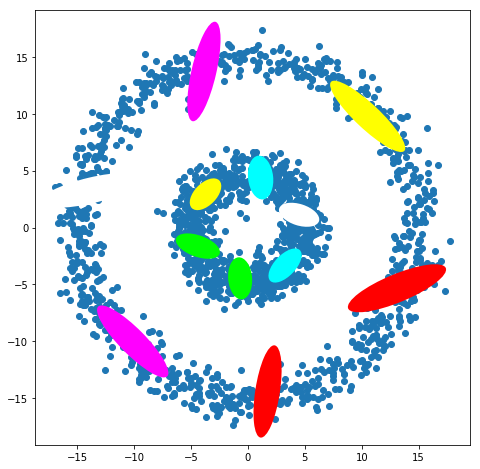

Iteration 91 : 0.07984627985388215


array([-15077.55322707, -13737.12774875, -13440.03522714, -13193.54648038,
       -12994.6929998 , -12858.22124931, -12759.86462942, -12699.75837591,
       -12654.8638801 , -12612.55067493, -12576.44026552, -12552.2272543 ,
       -12538.59770185, -12531.588166  , -12527.78901253, -12525.23022639,
       -12523.09920425, -12521.08493261, -12519.05315118, -12516.94152332,
       -12514.72806337, -12512.41840743, -12510.03361395, -12507.59361945,
       -12505.10136689, -12502.53548324, -12499.85269938, -12496.99521101,
       -12493.89970505, -12490.51046234, -12486.80372121, -12482.82669506,
       -12478.73109282, -12474.75329545, -12471.12112827, -12467.95336291,
       -12465.24690225, -12462.93614726, -12460.92558325, -12459.07358005,
       -12457.17232137, -12454.90706948, -12451.67280105, -12445.85930864,
       -12432.86799846, -12412.07144165, -12402.48893683, -12396.98750681,
       -12392.66041475, -12389.02484414, -12385.88038126, -12383.20730067,
       -12381.06881419, -

In [63]:
#[ANSQ6]

# 1.
def logsumexp(a,b):
    a,b = max(a,b), min(a,b)
    temp = a+np.log(1+np.exp(b-a))
    return temp
# 2. Iterate the sum... a+b+c == ((a+b)+c)
from functools import reduce

def much_logsumexp (A):
    if len(A.shape) == 1:
        return reduce(logsumexp, A)
    else:
        return np.array([reduce(logsumexp, row) for row in A])
# 3. 
# print(logsumexp(np.array([-1000]),np.array([-1001])))
# print(logsumexp(-1001,-1000))

# 4. See above
C = np.array([-1001,-1000,-1002])
# print(much_logsumexp(A))

class logMoG(MoG):

        def expectation(self):
            """Compute p(z|x,\theta)"""
            #[ANSQ2]
            evidence = np.zeros(self.data.shape[0])
            evidence = np.array(much_logsumexp(np.array([g.logprob(self.data)+np.log(p) for g, p in zip(self.lik, self.pi)]).T))    


            resp = np.array([g.logprob(self.data)+np.log(p)-evidence for g,p in zip(self.lik, self.pi)]).T

            ll = 0
            prob_matrix = np.array([g.logprob(self.data) for g in self.lik])
            for n in range(self.data.shape[0]):
                ll_i = much_logsumexp(np.array([np.log(self.pi[k]) + prob_matrix[k,n] for k in range(self.nMix)]))

                ll += ll_i


            return np.exp(np.array(resp)), ll

logmoga = logMoG(B, 12)
logmoga.em()
#[/ANSQ6]
